<a href="https://colab.research.google.com/github/aaravbmb/ML-speech-analysis-system/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Speech Analysis System

In [ ]:
# Importing Libraries

# General Libraries
import numpy as np
import pandas as pd
import os
import wave
import matplotlib.pyplot as plt

# Project-Specific Libraries
import librosa

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshitapanwar2711","key":"9fda017559ec7e3426e7d7509afb5eaa"}'}

In [ ]:
import os
import zipfile

# Move kaggle.json to correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d ravdess

Archive:  ravdess-emotional-speech-audio.zip
  inflating: ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-02-0

In [ ]:
# Extract MFCC from WAV Audio File
def extract_mfcc(wav_file_name):
  y, sr = librosa.load(wav_file_name)
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
  return mfccs

In [ ]:
# Loading RADVESS Speech Data
radvess_speech_labels = []
radvess_speech_data = []
for dirname, _, filenmames in os.walk('/content/ravdess/'):
  for filename in filenmames:
    radvess_speech_labels.append(int(filename[7:8]) - 1)
    wav_file_name = os.path.join(dirname, filename)
    radvess_speech_data.append(extract_mfcc(wav_file_name))

In [ ]:
# Convert data and labels to arrays
radvess_speech_data_array = np.array(radvess_speech_data)
radvess_speech_labels_array = np.array(radvess_speech_labels)

# Create categorical labels FIRST before augmenting
labels_categorical = to_categorical(radvess_speech_labels_array)

# Data Augmentation Functions
def add_noise(data, noise_level=0.02):
    return data + noise_level * np.random.randn(len(data))

def shift_time(data, shift_max=5):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift)

# Apply augmentation
augmented_data = [add_noise(x) for x in radvess_speech_data]
augmented_labels = labels_categorical  # Duplicate labels for augmentation

# Concatenate original and augmented data
radvess_speech_data_array = np.concatenate((radvess_speech_data_array, np.array(augmented_data)))
labels_categorical = np.concatenate((labels_categorical, augmented_labels))  # Now this is defined!

# Normalize MFCC features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
radvess_speech_data_array = scaler.fit_transform(radvess_speech_data_array)


In [ ]:
# Splitting Data into Training and Testing Data
x_train, x_test, y_train, y_test = train_test_split(np.array(radvess_speech_data_array), labels_categorical, test_size=0.2, random_state=9)

# Expand dimensions for LSTM (to make shape (samples, 40, 2))
x_train = np.expand_dims(x_train, -1)
x_train = np.repeat(x_train, 2, axis=-1)  # Repeat to create two input channels

x_test = np.expand_dims(x_test, -1)
x_test = np.repeat(x_test, 2, axis=-1)
number_of_samples = radvess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [ ]:
# Creating the LSTM Model
def create_model_LSTM():
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape=(40, 1)))
  model.add(Dropout(0.4))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dropout(0.4))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0005), metrics=['accuracy'])
  return model


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ✅ Ensure model is created before training
model_A = create_model_LSTM()  # Add this line if model_A is missing

# Define the learning rate reduction strategy
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Train the model with learning rate scheduling
history = model_A.fit(np.expand_dims(radvess_speech_data_array[:training_samples], -1),
                      labels_categorical[:training_samples],
                      validation_data=(np.expand_dims(radvess_speech_data_array[training_samples:training_samples+validation_samples], -1),
                                       labels_categorical[training_samples:training_samples+validation_samples]),
                      epochs=130,
                      shuffle=True,
                      callbacks=[lr_reduction])  # Add the callback here


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/130
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1622 - loss: 2.0630 - val_accuracy: 0.2622 - val_loss: 1.9557 - learning_rate: 5.0000e-04
Epoch 2/130
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2368 - loss: 1.9485 - val_accuracy: 0.2639 - val_loss: 1.8701 - learning_rate: 5.0000e-04
Epoch 3/130
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2864 - loss: 1.8742 - val_accuracy: 0.2899 - val_loss: 1.8063 - learning_rate: 5.0000e-04
Epoch 4/130
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2857 - loss: 1.8308 - val_accuracy: 0.2656 - val_loss: 1.8275 - learning_rate: 5.0000e-04
Epoch 5/130
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3045 - loss: 1.8068 - val_accuracy: 0.2899 - val_loss: 1.7789 - learning_rate: 5.0000e-04
Epoch 6/130
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3118 - loss: 1.7975 - val_accuracy: 0.2847 - val_loss: 1.7635 - learning_rate: 5.0000e-04
Epoch 7/130
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - ac

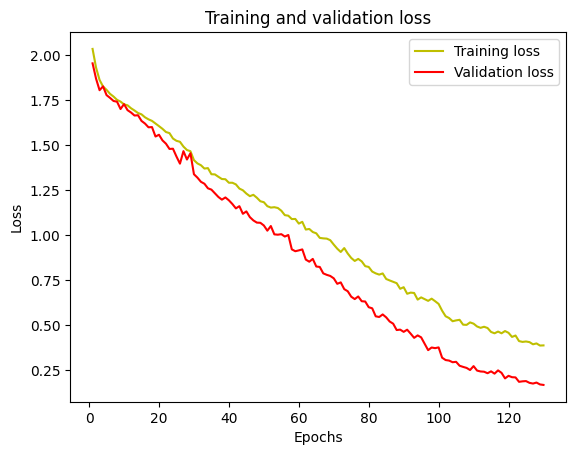

In [ ]:
# Loss Plot for LSTM Model

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

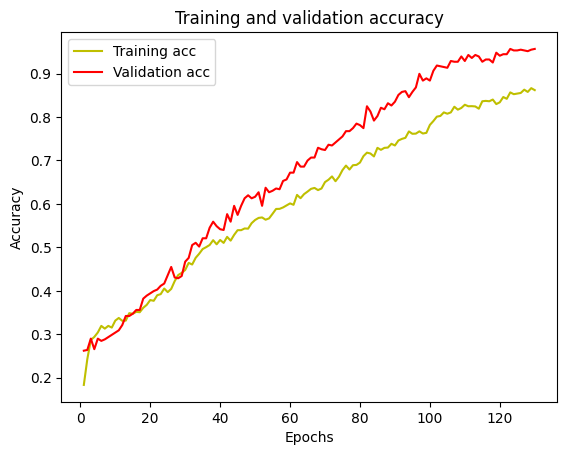

In [ ]:
# Accuracy Plots using LSTM Model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Accuracy: 95.31%


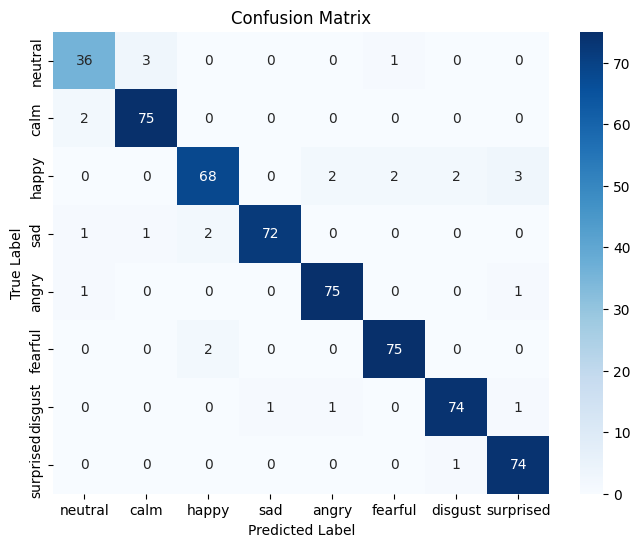

In [33]:
from sklearn.metrics import accuracy_score

# Get model predictions on the test set
y_pred = model_A.predict(np.expand_dims(radvess_speech_data_array[training_samples+validation_samples:], -1))

# Convert predictions and actual labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(labels_categorical[training_samples+validation_samples:], axis=1)

# Compute accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions.values(), yticklabels=emotions.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# Predicting Emotions

emotions = {1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 : 'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}

def predict(wav_filepath):
  test_point = extract_mfcc(wav_filepath)
  test_point = np.reshape(test_point, newshape=(1,40,1))
  predictions = model_A.predict(test_point)
  print(emotions[np.argmax(predictions[0])+1])

In [35]:
# Testing Model using RADVESS Audio

predict('/content/ravdess/Actor_10/03-01-03-02-01-02-10.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
fearful


In [36]:
# Saving Model for Use in Streamlit Application

model_A.save('emotionrecognition.h5')